# Figures pour le papier Digital Twins

In [1]:
from snake_ai.envs import RandomObstaclesEnv
from snake_ai.envs.geometry import Rectangle
import snake_ai.utils.visualization as vis

import scipy.sparse as sp
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as splinalg
import tqdm

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.5.2 (SDL 2.28.4, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html
[Taichi] version 1.6.0, llvm 15.0.4, commit f1c6fbbd, linux, python 3.10.13


[I 05/04/24 02:04:48.753 54019] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


## Définition des différences finies

In [2]:
def create_laplacian_matrix_2d(
    nx: int, ny: int, dx: float, dy: float
) -> sp.lil_array:
    Dxx = sp.diags([1, -2, 1], [-1, 0, 1], shape=(nx, nx)) / dx**2
    Dyy = sp.diags([1, -2, 1], [-1, 0, 1], shape=(ny, ny)) / dy**2
    return sp.kronsum(Dyy, Dxx, format="csr")


def create_laplacian_matrix_3d(
    nx: int, ny: int, nz: int, dx: float, dy: float, dz: float
) -> sp.lil_array:
    # Compute the 2D laplacian matrix
    laplace_2d = create_laplacian_matrix_2d(nx, ny, dx, dy)

    Dzz = sp.diags([1, -2, 1], [-1, 0, 1], shape=(nz, nz)) / dz**2
    return sp.kronsum(Dzz, laplace_2d, format="csr")

In [3]:
# Definition of functions to convert between indices and subscripts
def ind2sub_2D(array_shape, ind):
    rows = (ind / array_shape[1])
    cols = ind % array_shape[1]
    return np.array([rows, cols], dtype='int')

def sub2ind_2D(array_shape, rows, cols):
    return int(rows*array_shape[1] + cols)

In [4]:
def apply_dirichlet_2D(A: sp.spmatrix, binary_map: np.ndarray):
    """Apply the Dirichlet boundary conditions to the linear system.

    Args:
        A (sp.spmatrix): Sparse matrix of the linear system Ax = b
        binary_map (np.ndarray): binary map of the domain, where 1 correspond to spaces to apply the boundary conditions 
    """
    res = binary_map.shape
    max_index = np.prod(res)
    rhs = np.zeros(max_index)
    assert A.shape == (max_index, max_index), "Shape mismatch between the matrix and the binary map"  

    rows, cols = np.nonzero(binary_map)   
    for i, j in tqdm.tqdm(zip(rows, cols), total=len(rows)):
        index = sub2ind_2D(res, i, j)
        
        A[index, index] = 1
        rhs[index] = binary_map[i, j]
        
        ind_o = sub2ind_2D(res, i + 1, j)
        ind_e = sub2ind_2D(res, i - 1, j)
        ind_n = sub2ind_2D(res, i, j + 1)
        ind_s = sub2ind_2D(res, i, j - 1)
        
        for neighbour_ind in [ind_o, ind_e, ind_n, ind_s]:
            # Set the row to the identity vector and apply the colums to rhs
            if neighbour_ind >= 0 and neighbour_ind < max_index:
                A[index, neighbour_ind] = 0
                rhs[neighbour_ind] -= A[neighbour_ind, index] * rhs[index]
                A[neighbour_ind, index] = 0
    return A, rhs

## Utilisation d'environements existants

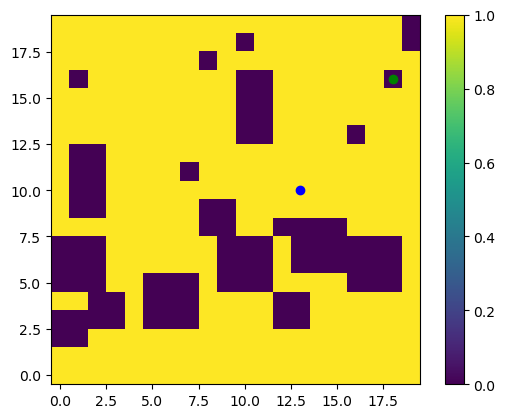

In [5]:
env = RandomObstaclesEnv(pixel=1, nb_obs=20, max_obs_size=3)
env.reset()
plt.imshow(env._free_position_mask, origin='lower')
plt.plot(env.goal.y, env.goal.x, 'go')
plt.plot(env.agent.position.y, env.agent.position.x, 'bo')
plt.colorbar()

# Definition d'environement à partir de carte binaires 

In [6]:
binary_map = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,1,1,1,1,0,0,0,1,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0,1,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0],
    [0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0,1,1,1,1,1,1,1,1,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
])
binary_map.shape

obstacles = [Rectangle(x, y, 1, 1) for x, y in zip(*np.where(binary_map == 1))]


In [7]:
res = 20
x_max, y_max = binary_map.shape

new_obs_map = np.zeros((x_max * res, y_max * res))
for x, y in np.argwhere(binary_map):
    new_obs_map[x*res:(x+1)*res, y*res:(y+1)*res] = 1

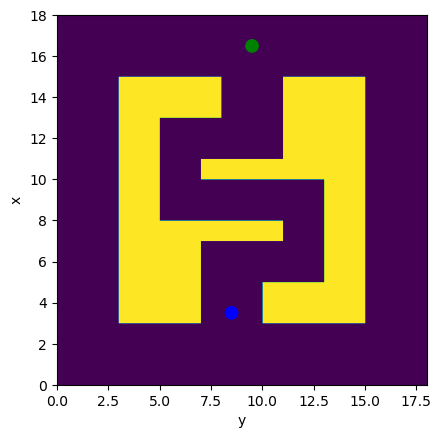

In [20]:
init_pos = np.array([3.5, 8.5])
goal_pos = np.array([16.5, 9.5])
fig, ax = plt.subplots()
ax.imshow(new_obs_map, origin='lower', extent=[0, x_max, 0, y_max])
ax.set(xlabel='y', ylabel='x')
ax.add_patch(plt.Circle(init_pos[::-1], 0.3, color="blue"))
ax.add_patch(plt.Circle(goal_pos[::-1], 0.3, color="green"))   

100%|██████████| 1/1 [00:00<00:00, 1016.06it/s]


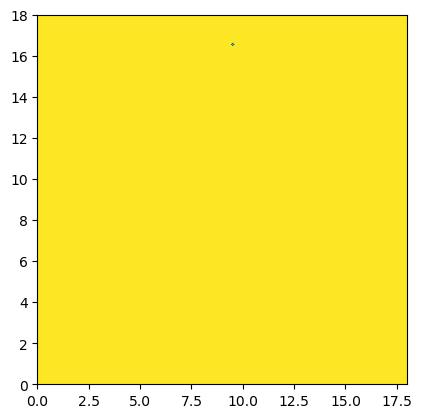

In [10]:
## 
step = np.array(binary_map.shape) / np.array(new_obs_map.shape)
laplace = create_laplacian_matrix_2d(*new_obs_map.shape, *step)
rhs = np.zeros(new_obs_map.shape)
goal_ind = np.array(goal_pos * res, dtype=int)
rhs[goal_ind[0], goal_ind[1]] = 1e3
laplace, rhs = apply_dirichlet_2D(laplace, rhs)
plt.imshow(rhs.reshape(new_obs_map.shape), origin='lower', extent=[0, x_max, 0, y_max])
# plt.imshow(new_obs_map, origin='lower', extent=[0, x_max, 0, y_max])

In [11]:
valid_ind = new_obs_map.flat == 0
A = laplace[valid_ind][:, valid_ind]
b = rhs.flat[valid_ind]
x = splinalg.spsolve(A, b)
solution = np.zeros(new_obs_map.shape, dtype=float)
solution.flat[valid_ind] = x

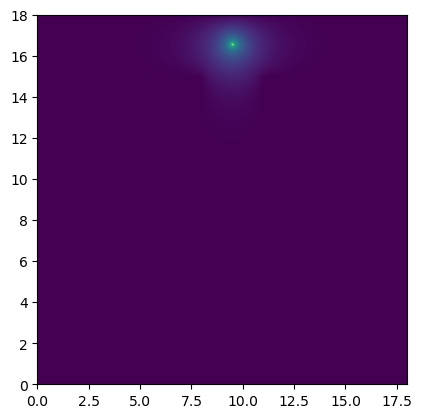

In [12]:
plt.imshow(solution, origin='lower', extent=[0, x_max, 0, y_max])


## Now let's run differentiable simulations
Here we want to run a simulation with bending constraints.

In [13]:
from typing import List
import taichi as ti
import taichi.math as tm

from snake_ai.diffsim.walk_simulation import WalkerSimulationStoch2D
from snake_ai.diffsim.field import ScalarField
from snake_ai.envs.geometry import Rectangle

@ti.data_oriented
class BendingSimulation(WalkerSimulationStoch2D):
    def __init__(self, positions: np.ndarray, potential_field: ScalarField, obstacles: List[Rectangle] = None, t_max: float = 100, dt: float = 0.1, diffusivity: float = 1):
        super().__init__(positions, potential_field, obstacles, t_max, dt, diffusivity) 
        self.distance_loss = ti.field(dtype=ti.f32, shape=(), needs_grad=True)
        self.bending_loss = ti.field(dtype=ti.f32, shape=(), needs_grad=True)
        # self.obstacle_loss = ti.field(dtype=ti.f32, shape=(), needs_grad=True)
        self.total_loss = ti.field(dtype=ti.f32, shape=(), needs_grad=True)

    @ti.kernel
    def reset(self):
        for n in ti.ndrange(self.nb_walkers):
            self.states[n, 0].pos = self._init_pos[n]
            self.states[n, 0].vel = tm.vec2(0.0, 0.0)
            for t in ti.ndrange(self.nb_steps):
                self._noise[n, t] = tm.vec2(ti.randn(), ti.randn())
        for i, j in self.force_field._values:
            self.force_field._values.grad[i, j] = tm.vec2(0.0, 0.0)
        self.distance_loss[None] = 0.0
        self.bending_loss[None] = 0.0
        self.total_loss[None] = 0.0

    
    @ti.kernel
    def clip_force_field(self, clip_value: float):
        for i, j in self.force_field._values:
            if tm.length(self.force_field._values.grad[i, j]) > clip_value:
                self.force_field._values.grad[i, j] = (
                    clip_value
                    * self.force_field._values.grad[i, j]
                    / tm.length(self.force_field._values.grad[i, j])
                )
    @ti.kernel
    def compute_distance_loss(self, target : ti.template(), t : int):
        for n in range(self.nb_walkers):
            ti.atomic_add(self.distance_loss[None], tm.length(self.states[n, t].pos - target)**2)
    
    @ti.kernel
    def compute_bending_loss(self, min_diff : float):
        for n in range(self.nb_walkers):
            for t in range(1, self.nb_steps - 1):
                # F_t1 = self.states.pos[n, t] - self.states.pos[n, t - 1]
                # F_t2 = self.states.pos[n, t + 1] - self.states.pos[n, t]
                F_t1 = self.force_field._at_2d(self.states.pos[n, t])
                F_t2 = self.force_field._at_2d(self.states.pos[n, t + 1])
                ## Warning : for 2D force field, the cross product return a float
                cross_prod = tm.cross(F_t1, F_t2)
                bending = tm.atan2(ti.abs(cross_prod), tm.dot(F_t1, F_t2))
                # bending = tm.length(F_t2 - F_t1)
                ti.atomic_add(self.bending_loss[None], bending**2)
                # if tm.length(F_t1) < min_diff or tm.length(F_t2) < min_diff:
                #     ti.atomic_add(self.bending_loss[None], 0.0)
                # else:
                #     bending = tm.acos(tm.dot(F_t1, F_t2) / (tm.length(F_t1) * tm.length(F_t2)))
                #     ti.atomic_add(self.bending_loss[None], bending**2)

    @ti.kernel
    def compute_total_loss(self, distance : float, bending : float):
        self.total_loss[None] = distance * self.distance_loss[None] + bending * self.bending_loss[None]

In [21]:
ti.init(arch=ti.gpu)

nb_agents = 20
t_max = 100
dt = 0.1
diffusivity = 0.1

positions = np.repeat(init_pos.reshape(1, 2), 10, axis=0)
field = ScalarField(solution, Rectangle(0, 0, x_max, y_max))
bending_sim = BendingSimulation(positions, field, t_max=t_max, dt=dt, diffusivity=diffusivity, obstacles=obstacles)
bending_sim.reset()
bending_sim.run(diffusivity)
bending_sim.compute_bending_loss(1e-3)
print(bending_sim.bending_loss[None])

[Taichi] Starting on arch=cuda
12888.20703125


(0.0, 18.0)

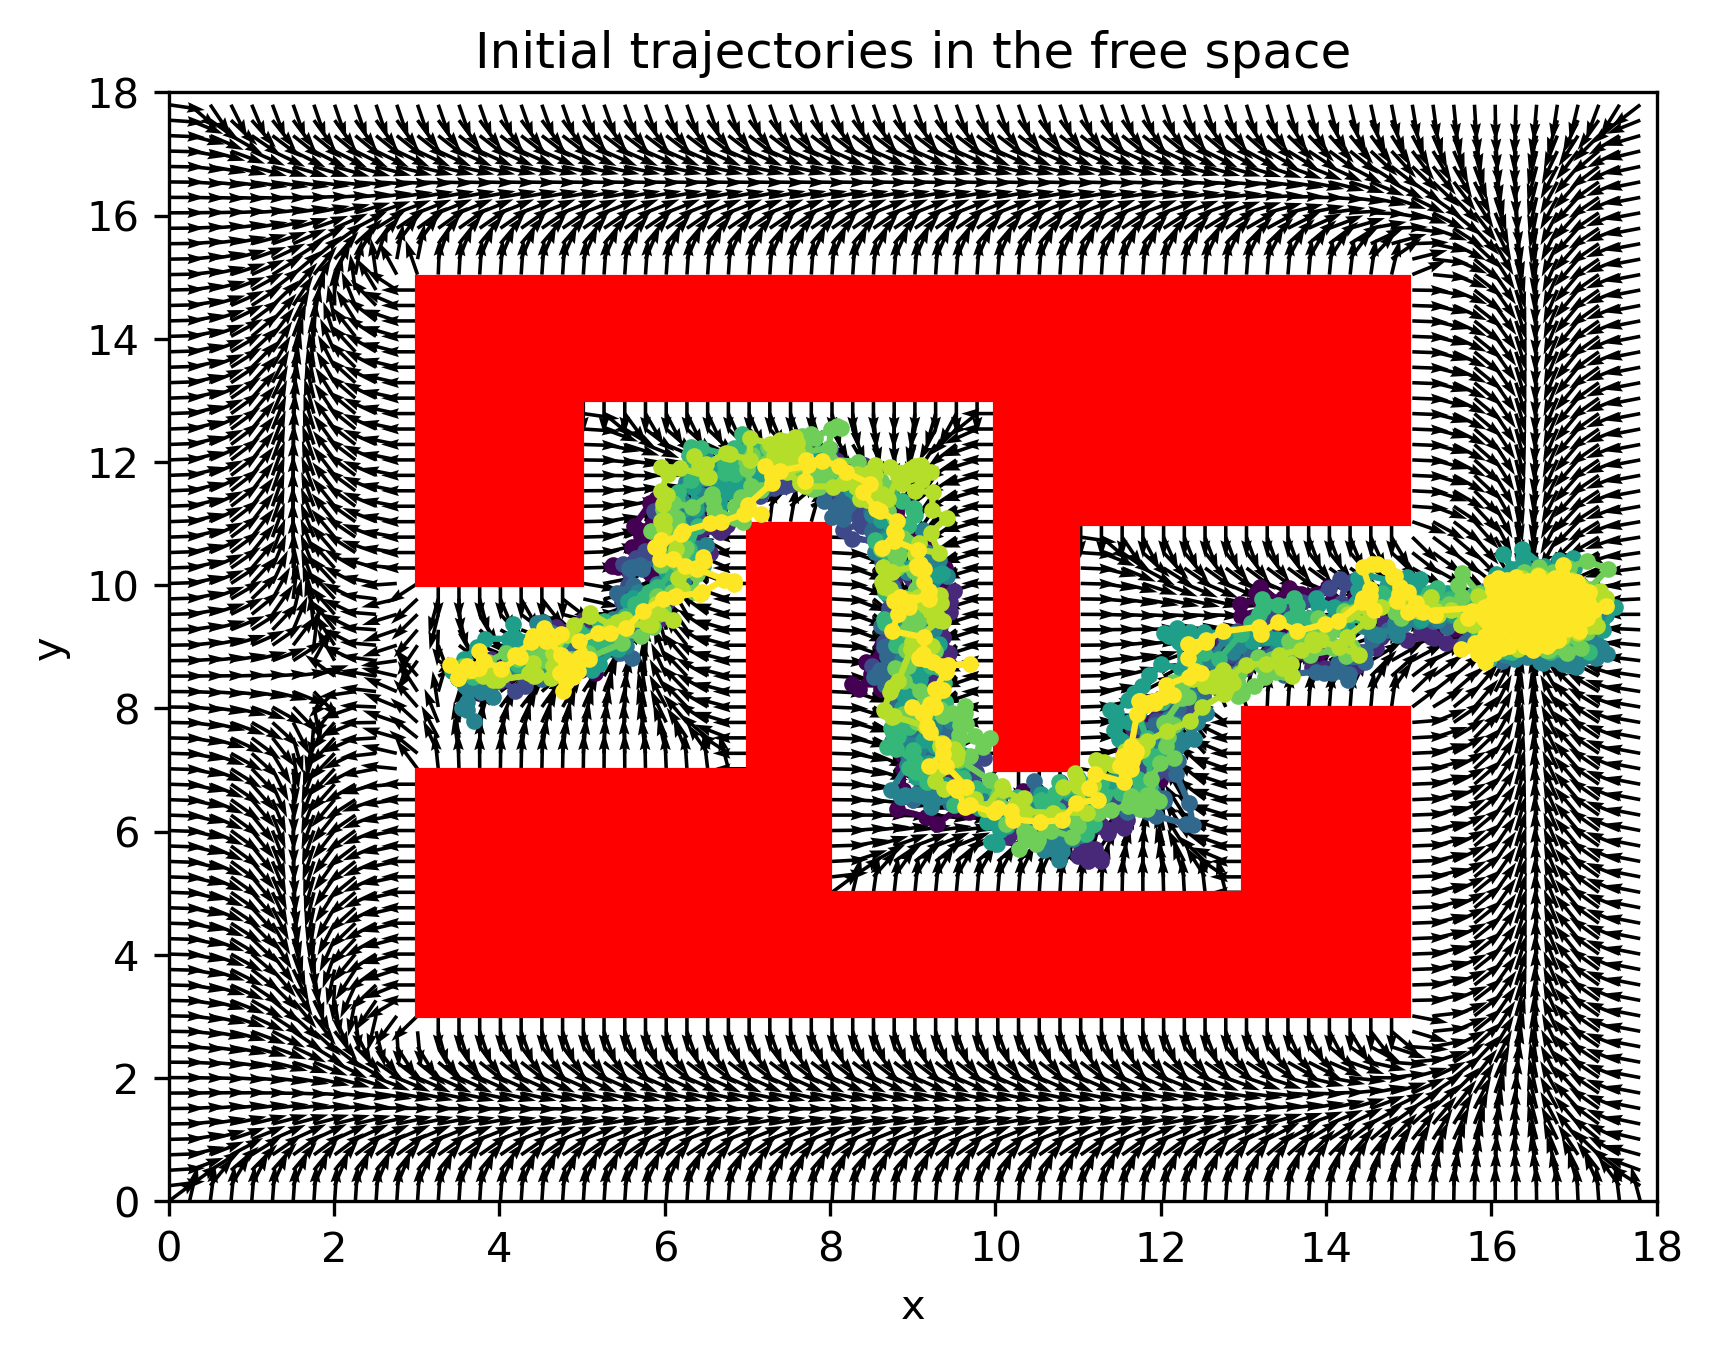

In [22]:
downscale = 5
scale = 2
# Visualisation
fig = vis.plot_2D_trajectory(bending_sim.positions, 
                             goal_pos, 
                             obstacles=obstacles, 
                             vector_field=bending_sim.force_field, 
                             downscale=downscale, 
                             scale = scale, 
                             title="Initial trajectories in the free space")
plt.xlim(0, x_max)
plt.ylim(0, y_max)

We can now try to optimize the force field to limit bending

In [23]:
max_iter = 100
lr = 0.01
clip = 10.0
# diffusivity=0.3
diffusivities = np.linspace(1, 0.1, max_iter)

w_distance, w_bend = 1.0, 1.0

best_loss = np.inf
best_vector_field = None

target = tm.vec2(goal_pos)
for iter in range(max_iter):
    bending_sim.reset()
    with ti.ad.Tape(bending_sim.total_loss):
        bending_sim.run(diffusivity=diffusivities[iter])
        bending_sim.compute_distance_loss(target, bending_sim.nb_steps - 1)
        bending_sim.compute_bending_loss(1e-6)
        bending_sim.compute_total_loss(w_distance, w_bend)
    if bending_sim.total_loss[None] < best_loss:
        best_loss = bending_sim.total_loss[None]
        best_vector_field = np.copy(bending_sim.force_field._values.to_numpy())
    print("Iter=", iter, "Loss=", bending_sim.total_loss[None], "Distance=", bending_sim.distance_loss[None], "Bending=", bending_sim.bending_loss[None])
    if clip > 0:
        bending_sim.clip_force_field(clip)
    bending_sim._update_force_field(lr)

Iter= 0 Loss= 4461.26904296875 Distance= 99.74552154541016 Bending= 4361.5234375
Iter= 1 Loss= 3964.078857421875 Distance= 32.01197814941406 Bending= 3932.06689453125
Iter= 2 Loss= 4489.04052734375 Distance= 26.281532287597656 Bending= 4462.7587890625
Iter= 3 Loss= 3974.157958984375 Distance= 47.62417221069336 Bending= 3926.53369140625
Iter= 4 Loss= 4176.75146484375 Distance= 41.17040252685547 Bending= 4135.5810546875
Iter= 5 Loss= 3806.341796875 Distance= 49.63938903808594 Bending= 3756.702392578125
Iter= 6 Loss= 4229.654296875 Distance= 78.23258972167969 Bending= 4151.421875
Iter= 7 Loss= 4091.668212890625 Distance= 42.930206298828125 Bending= 4048.738037109375
Iter= 8 Loss= 3779.639892578125 Distance= 62.86238479614258 Bending= 3716.777587890625
Iter= 9 Loss= 4153.62451171875 Distance= 60.44208526611328 Bending= 4093.1826171875
Iter= 10 Loss= 3673.611083984375 Distance= 52.92855453491211 Bending= 3620.6826171875
Iter= 11 Loss= 4020.240966796875 Distance= 31.422740936279297 Bending= 

[E 05/04/24 02:08:41.644 54019] [cuda_driver.h:operator()@92] CUDA Error CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered while calling malloc_async_impl (cuMemAllocAsync)


RuntimeError: [cuda_driver.h:operator()@92] CUDA Error CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered while calling malloc_async_impl (cuMemAllocAsync)

(0.0, 18.0)

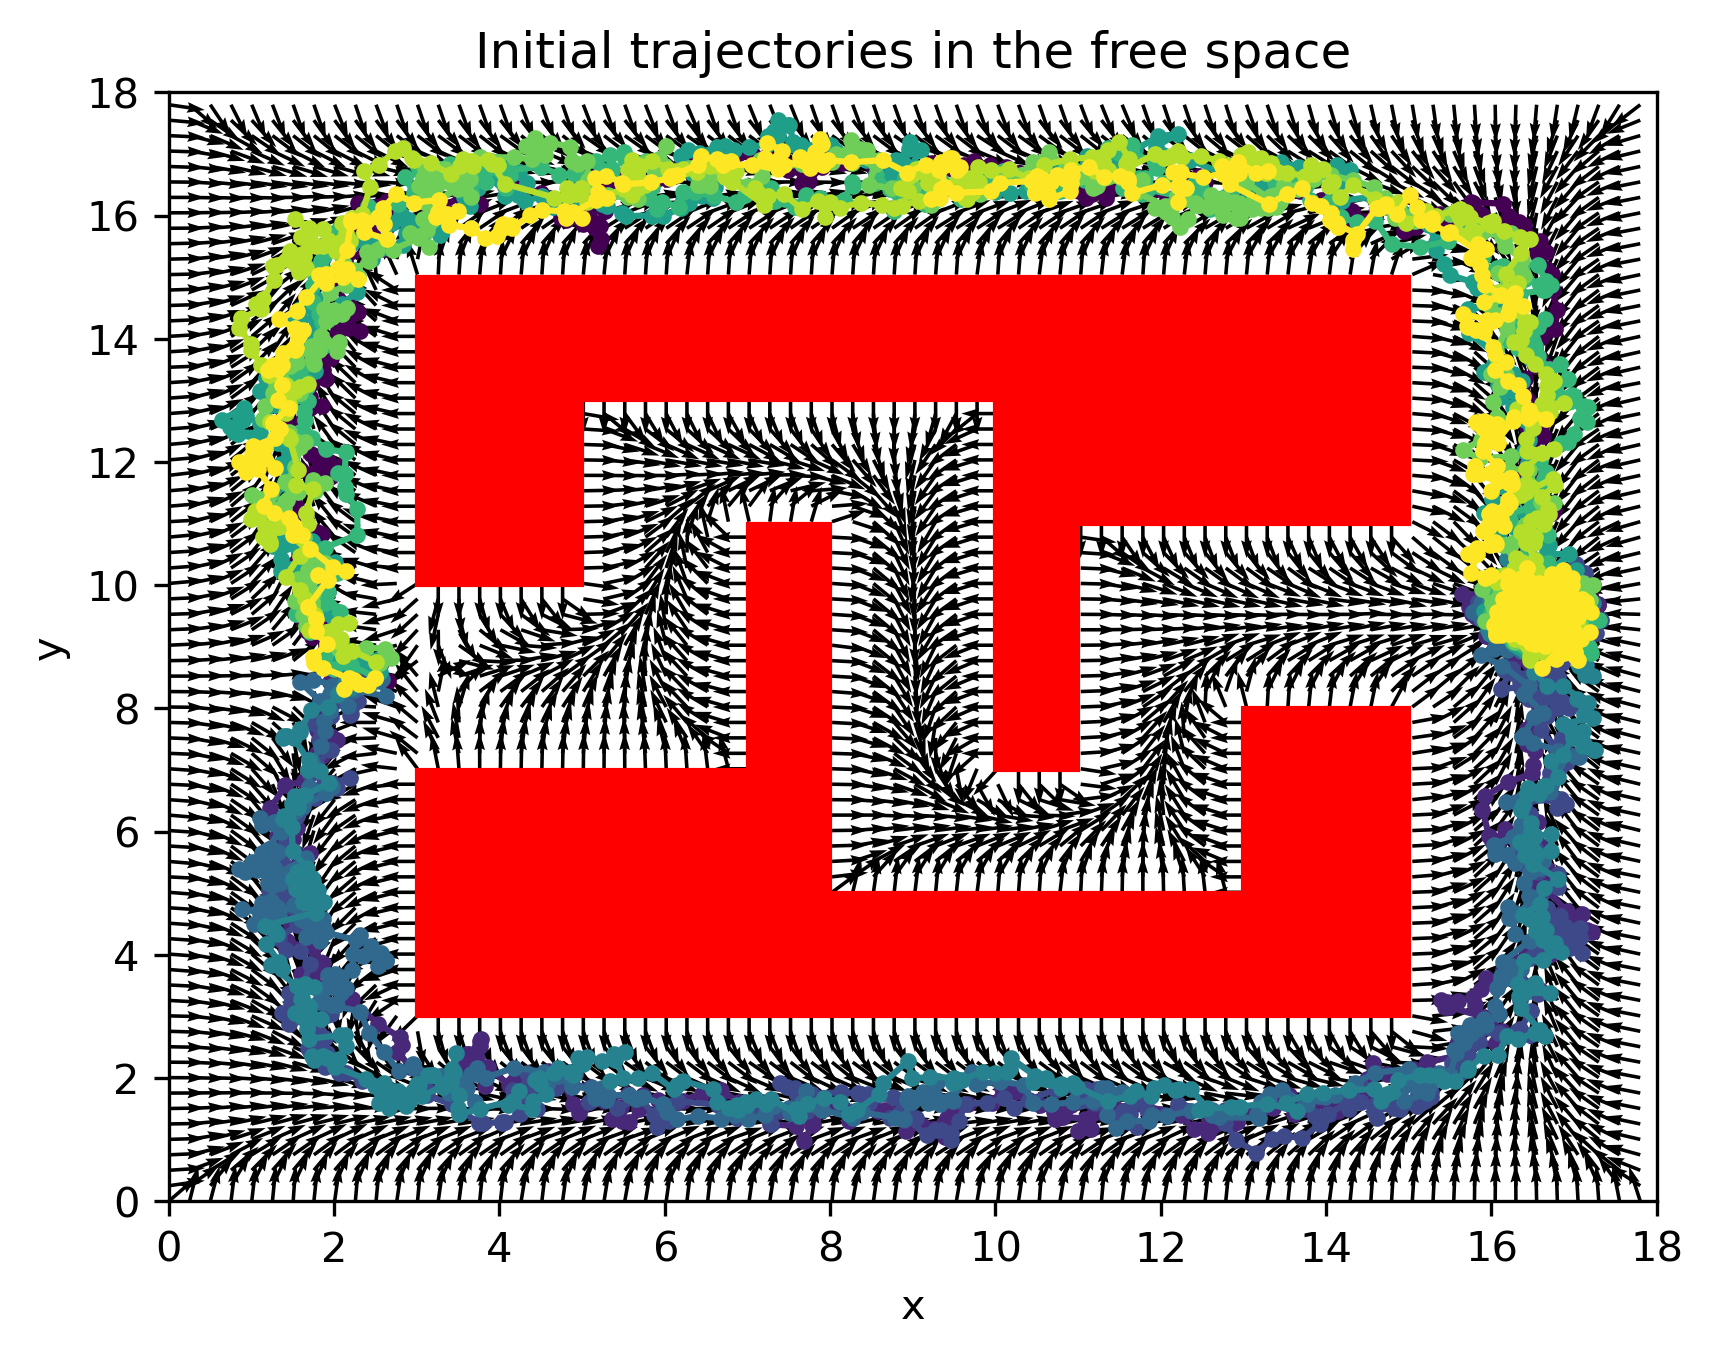

In [19]:
downscale = 5
scale = 2
# Visualisation
fig = vis.plot_2D_trajectory(bending_sim.positions, 
                             goal_pos, 
                             obstacles=obstacles, 
                             vector_field=bending_sim.force_field, 
                             downscale=downscale, 
                             scale = scale, 
                             title="Initial trajectories in the free space")
plt.xlim(0, x_max)
plt.ylim(0, y_max)